In [20]:
import tensorflow as tf
from tensorflow.keras import layers, utils
import matplotlib.pyplot as plt

In [85]:
# Load and preprocess data
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.reshape(-1, 32, 32, 3, 1)
train_images = (train_images - 127.5) / 127.5 # Normalize to [-1, 1]

BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [123]:
# Generator model
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(4*4*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((4, 4, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh') 
    ])
    return model

# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3], data_format="channels_last"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

In [30]:
# Loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [141]:
# Optimizers
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training function
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return generated_images[0]

c:\Users\coope\Documents\GenAI\GenAI-A4\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\coope\Documents\GenAI\GenAI-A4\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/50 ━━━━━━━━━━━━━━━━━━━━ 1:06:13 99s/epoch

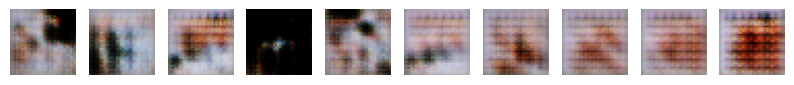

20/50 ━━━━━━━━━━━━━━━━━━━━ 49:46 100s/epoch

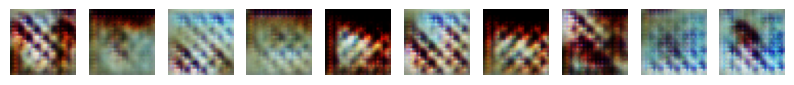

30/50 ━━━━━━━━━━━━━━━━━━━━ 33:07 99s/epoch

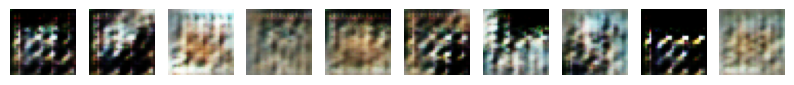

40/50 ━━━━━━━━━━━━━━━━━━━━ 16:34 99s/epoch

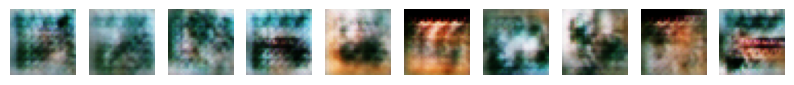

50/50 ━━━━━━━━━━━━━━━━━━━━ 4877s 100s/epoch


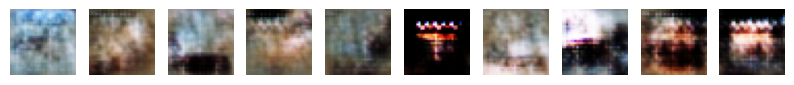

In [145]:
# Training loop
def train(dataset, epochs, num_images_saved_per_epoch=10):
    progbar = utils.Progbar(epochs, interval=1, unit_name='epoch')
    for epoch in range(epochs):
        save_images = (epoch + 1) % 10 == 0
        progbar.add(1)
        if save_images:
            fig, axs = plt.subplots(1, num_images_saved_per_epoch, figsize=(num_images_saved_per_epoch, 1.5))

        for i, image_batch in enumerate(dataset):
            image = train_step(image_batch)
            if save_images and i < num_images_saved_per_epoch:
                image = (image + 1) / 2
                axs[i].imshow(image)
                axs[i].axis('off')
        if save_images:
            plt.show()

            

            

# Run the training
train(train_dataset, epochs=50)